<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data and Kaggle Challenge

## Part 3

### Kaggle Submissions

I have chosen 4 models to submit to Kaggle. I will be submitting the lasso and ridge models for both 3rd and 4th model, making a total of 6 submissions.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    LassoCV,
    Ridge,
    RidgeCV,
)

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler
)

### Data cleaning

As a new data set is introduced, I have decided to re-clean both datasets after concatenating the datasets.

In [2]:
# Importing raw data
ames = pd.read_csv('../datasets/train.csv')
kaggle = pd.read_csv('../datasets/test.csv')

In [3]:
# Remove outliers as previously identified
outliers_id = [1499, 2181, 2116, 2072, 2261]
for outlier in outliers_id:
    ames.drop(ames.index[ames['Id']==outlier], inplace=True)

In [4]:
# Concatenate data sets
kaggle_sub = pd.concat(
    objs=[ames, kaggle],
    axis=0
)

In [5]:
# Convert columns to previous format
kaggle_sub.columns = kaggle_sub.columns.str.lower()
kaggle_sub.columns = kaggle_sub.columns.str.replace(' ', '_')

In [6]:
kaggle_sub

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500.0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000.0
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000.0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000.0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2007,WD,NaN
874,1234,535126140,60,RL,90.0,14670,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,NaN,0,8,2008,WD,NaN
875,1373,904100040,20,RL,55.0,8250,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,8,2008,WD,NaN
876,1672,527425140,20,RL,60.0,9000,Pave,NaN,Reg,Lvl,...,0,0,NaN,GdWo,NaN,0,5,2007,WD,NaN


In [7]:
# Check for null values
kaggle_sub.isnull().sum().sum()

14850

In [8]:
# dropping identified columns with null values
kaggle_sub.drop(columns=['pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu'], inplace=True)

In [9]:
# As the test data set has null values for saleprice, I have to drop it to prevent auto filling with 0
kaggle_sub_na = kaggle_sub.drop(columns=['saleprice'])

# Substituting null values with 0 as previously identified.
for col in kaggle_sub_na.columns:
    kaggle_sub[col] = kaggle_sub[col].fillna(0)

In [10]:
kaggle_sub.isnull().sum().sum()

878

This number is correct as there is 878 entries in the test data set and there is no values for saleprice for these 878 entries.

In [11]:
# create a function to convert grades to numbers

def qual_to_num(quality):
    if type(quality) != str:
        return quality
    else:
        quality = quality.lower()
        if quality == 'ex':
            quality = 5
        elif quality == 'gd':
            quality = 4
        elif quality == 'ta':
            quality = 3
        elif quality == 'fa':
            quality = 2
        elif quality == 'po':
            quality = 1
        else:
            quality = 0
        return quality
    

In [12]:
# creating a list for all quality grades to be converted
col_list = []

for col in kaggle_sub.columns:
    if 'qual' in col or 'cond' in col or 'qc' in col:
        col_list.append(col)

In [13]:
# Checking on the list created
col_list

['condition_1',
 'condition_2',
 'overall_qual',
 'overall_cond',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'heating_qc',
 'low_qual_fin_sf',
 'kitchen_qual',
 'garage_qual',
 'garage_cond']

In [14]:
# Removing of column names which were inadvertedly added.
col_list.remove('condition_1')
col_list.remove('condition_2')

In [15]:
# convert the values in all quality columns
for col in col_list:
    kaggle_sub[col] = kaggle_sub[col].map(qual_to_num)

In [16]:
# Adding Age columns to the data
kaggle_sub['age_since_remodel'] = kaggle_sub['yr_sold'] - kaggle_sub['year_remod/add']
kaggle_sub['age'] = kaggle_sub['yr_sold'] - kaggle_sub['year_built']

In [17]:
avg_neighborhood = kaggle_sub.groupby('neighborhood')['saleprice'].mean()
avg_neighborhood 

neighborhood
Blmngtn    200417.681818
Blueste    144566.666667
BrDale     103371.052632
BrkSide    127022.697368
ClearCr    211729.280000
CollgCr    202497.216667
Crawfor    205901.211268
Edwards    129905.787234
Gilbert    189228.387931
Greens     188666.666667
GrnHill    280000.000000
IDOTRR     101103.188406
Landmrk    137000.000000
MeadowV    100231.250000
Mitchel    167656.707317
NAmes      145905.816129
NPkVill    140476.470588
NWAmes     194619.022989
NoRidge    316294.125000
NridgHt    322831.352459
OldTown    125276.300613
SWISU      134758.875000
Sawyer     137181.909910
SawyerW    187760.160920
Somerst    227183.900000
StoneBr    329675.736842
Timber     240492.872340
Veenker    253570.588235
Name: saleprice, dtype: float64

In [18]:
# Creating a dictionary
neighborhood_dict = avg_neighborhood.to_dict()

# Dividing the values by 100000
for key, value in neighborhood_dict.items():
    neighborhood_dict[key] = round((value/100000), 2)
neighborhood_dict

{'Blmngtn': 2.0,
 'Blueste': 1.45,
 'BrDale': 1.03,
 'BrkSide': 1.27,
 'ClearCr': 2.12,
 'CollgCr': 2.02,
 'Crawfor': 2.06,
 'Edwards': 1.3,
 'Gilbert': 1.89,
 'Greens': 1.89,
 'GrnHill': 2.8,
 'IDOTRR': 1.01,
 'Landmrk': 1.37,
 'MeadowV': 1.0,
 'Mitchel': 1.68,
 'NAmes': 1.46,
 'NPkVill': 1.4,
 'NWAmes': 1.95,
 'NoRidge': 3.16,
 'NridgHt': 3.23,
 'OldTown': 1.25,
 'SWISU': 1.35,
 'Sawyer': 1.37,
 'SawyerW': 1.88,
 'Somerst': 2.27,
 'StoneBr': 3.3,
 'Timber': 2.4,
 'Veenker': 2.54}

In [19]:
kaggle_sub['neighborhood_value'] = kaggle_sub['neighborhood'].apply(lambda x: neighborhood_dict[x])


In [20]:
kaggle_sub

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,age_since_remodel,age,neighborhood_value
0,109,533352170,60,RL,0.0,13517,Pave,IR1,Lvl,AllPub,...,0,0,0,3,2010,WD,130500.0,5,34,1.37
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,...,0,0,0,4,2009,WD,220000.0,12,13,1.88
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,...,0,0,0,1,2010,WD,109000.0,3,57,1.46
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,...,0,0,0,4,2010,WD,174000.0,3,4,2.40
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,...,0,0,0,3,2010,WD,138500.0,17,110,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,Reg,Lvl,AllPub,...,0,0,0,11,2007,WD,NaN,33,33,1.95
874,1234,535126140,60,RL,90.0,14670,Pave,Reg,Lvl,AllPub,...,0,0,0,8,2008,WD,NaN,9,42,1.46
875,1373,904100040,20,RL,55.0,8250,Pave,Reg,Lvl,AllPub,...,0,0,0,8,2008,WD,NaN,40,40,1.37
876,1672,527425140,20,RL,60.0,9000,Pave,Reg,Lvl,AllPub,...,0,0,0,5,2007,WD,NaN,36,36,1.46


### Kaggle Model submission 1

For the first model submission, I will be using the model 3 out of the 6 models which were created previously.

In [21]:
kaggle_dummies = pd.get_dummies(
    data=kaggle_sub,
    drop_first=True,
    columns=[
        'ms_subclass', 'ms_zoning', 'functional', 'foundation',
        'condition_1', 'central_air'
])

In [22]:
x_var_model_kaggle = kaggle_dummies.drop(columns= [
    # features to keep
    #'overall_qual', 'gr_liv_area','garage_area',
    #'age', 'neighborhood_value', 'totrms_abvgrd',
    #'full_bath', 'exter_qual', 'total_bsmt_sf',
    #'bsmt_qual', 'mas_vnr_area'
    
    # unwanted features
    'id', 'pid', 'lot_frontage', 'lot_area', 'street', 'lot_shape',
    'land_contour', 'utilities', 'lot_config','land_slope',
    'neighborhood', 'condition_2', 'bldg_type','house_style',
    'overall_cond', 'year_built','year_remod/add','roof_style',
    'roof_matl', 'exterior_1st','exterior_2nd','mas_vnr_type',
    'exter_cond', 'bsmt_cond', 'bsmt_exposure','bsmtfin_type_1',
    'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2','bsmt_unf_sf',
    'heating', 'heating_qc','electrical', '1st_flr_sf','2nd_flr_sf',
    'low_qual_fin_sf','bsmt_full_bath', 'bsmt_half_bath','half_bath',
    'bedroom_abvgr', 'kitchen_abvgr', 'fireplaces','garage_type',
    'garage_yr_blt', 'garage_finish', 'garage_cars','garage_qual',
    'garage_cond', 'paved_drive', 'wood_deck_sf','open_porch_sf',
    'enclosed_porch', '3ssn_porch', 'screen_porch','pool_area',
    'misc_val', 'mo_sold', 'yr_sold', 'sale_type','age_since_remodel',
    
    # y to be kept
    #'saleprice'
])

As the test and train data set were cleaned together, we need to separate them so that we can predict the saleprice for the test data.

In [23]:
# Creating the train data set
x_var_model = x_var_model_kaggle.dropna()

In [24]:
# Separating the test data set
kaggle_model = x_var_model_kaggle[x_var_model_kaggle['saleprice'].isna()]

In [25]:
# Check if the number of rows are correct.
x_var_model

,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,gr_liv_area,full_bath,kitchen_qual,totrms_abvgrd,garage_area,...,foundation_Wood,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,central_air_Y
0,6,289.0,4,3,725.0,1479,2,4,6,475.0,...,0,0,0,0,0,1,0,0,0,1
1,7,132.0,4,4,913.0,2122,2,4,8,559.0,...,0,0,1,0,0,0,0,0,0,1
2,5,0.0,3,3,1057.0,1057,1,4,5,246.0,...,0,0,1,0,0,0,0,0,0,1
3,5,0.0,3,4,384.0,1444,2,3,7,400.0,...,0,0,1,0,0,0,0,0,0,1
4,6,0.0,3,2,676.0,1445,2,3,6,484.0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8,0.0,4,4,1884.0,1728,2,4,7,520.0,...,0,0,1,0,0,0,0,0,0,1
2047,4,0.0,3,3,861.0,861,1,3,4,539.0,...,0,0,1,0,0,0,0,0,0,1
2048,6,0.0,3,3,896.0,1913,1,3,9,342.0,...,0,0,1,0,0,0,0,0,0,1
2049,4,0.0,3,3,1200.0,1200,1,3,6,294.0,...,0,0,1,0,0,0,0,0,0,1


In [26]:
# Check if the number of rows are correct.
kaggle_model

,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,gr_liv_area,full_bath,kitchen_qual,totrms_abvgrd,garage_area,...,foundation_Wood,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,central_air_Y
0,6,0.0,3,2,1020.0,1928,2,2,9,440.0,...,0,0,1,0,0,0,0,0,0,0
1,5,0.0,3,4,1967.0,1967,2,3,10,580.0,...,0,0,1,0,0,0,0,0,0,1
2,7,0.0,4,4,654.0,1496,2,4,7,426.0,...,0,0,1,0,0,0,0,0,0,1
3,5,0.0,4,3,968.0,968,1,3,5,480.0,...,0,0,1,0,0,0,0,0,0,1
4,6,247.0,3,4,1394.0,1394,1,3,6,514.0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,6,0.0,3,3,1084.0,1877,2,3,8,488.0,...,0,0,0,0,1,0,0,0,0,1
874,6,410.0,4,3,1104.0,1988,2,4,9,480.0,...,0,0,1,0,0,0,0,0,0,1
875,5,0.0,3,3,952.0,1211,1,3,5,322.0,...,0,1,0,0,0,0,0,0,0,1
876,4,0.0,3,3,864.0,864,1,3,5,528.0,...,0,0,1,0,0,0,0,0,0,1


In [27]:
# Creating a list of the columns excluding saleprice
features_K = [col for col in kaggle_model._get_numeric_data().columns if col != 'saleprice']

# Assembling X variable for the test data.
KX = kaggle_model[features_K]

# Assembling X and y variables.
X = x_var_model[features_K]
y = x_var_model['saleprice']

# Scaling the variables to train data X
ss = StandardScaler()
ss.fit(X)
Z = ss.transform(X)
KZ = ss.transform(KX)

# Instatiating the Lasso model for the first submission
lasso = LassoCV(n_alphas=200)

# Fitting the model
lasso.fit(Z, y)

# Calculating the best alpha for this model 
lasso.alpha_

84.07232955432565

In [28]:
# Reinstantiate Lasso with the best alpha.
lasso_best = Lasso(alpha=84.07232955432565)

# Fitting the model
lasso_best.fit(Z, y)

# Generate the predictions for the Saleprice
SalePrice = lasso_best.predict(KZ)

In [29]:
SalePrice

array([153791.37480806, 189729.06717379, 189106.09113682, 134283.09150956,
       183927.65934914,  69689.3212399 , 109711.00674368, 175123.29946114,
       203194.30472562, 155552.35388746, 168353.0684269 , 127527.86781805,
       167532.82512542, 240654.10057886, 154150.88782597,  82821.34697218,
       149150.61700625, 124419.45442   , 193927.00974477, 191429.72390842,
       135252.98995505, 111570.11043971, 205416.36732449, 151003.05840568,
       208451.378814  , 123058.24923877, 120550.44161603, 144463.25218966,
       151993.77791227,  27308.86723368, 111890.20197034, 117465.16409862,
       274325.92289832, 170401.19620965, 234917.75236641, 172460.99601183,
       119916.62432595,  74373.9622013 , 122169.66388914, 221809.56347588,
       159192.17949999, 216035.28327987, 161555.62821207, 154427.82579823,
       223926.26073289,  75611.52722303, 228395.22803747, 121233.50422627,
       115863.40532534, 115613.74072251, 118209.40981147, 211331.93108718,
       261270.61731662, 1

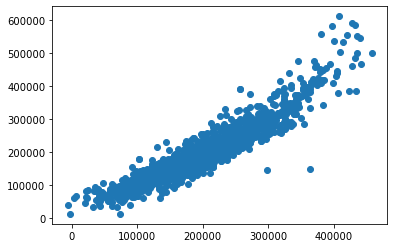

In [30]:
plt.scatter(lasso_best.predict(Z),y);

In [31]:
# Creating the submission DataFrame
kaggle_sub1 = pd.DataFrame({
    'Id': kaggle['Id'],
    'SalePrice': SalePrice
})
    

In [32]:
# Creating a csv file to be submitted
kaggle_sub1.to_csv('../submissions/Kaggle_sub_final1.csv', index=False)

Kaggle RMSE score for this model was 32850.54108 which was to be expected as there were other better models.

### Kaggle Submission 2

For the 2nd submission, I will be using model 4 out of 6.

In [33]:
# Recreating the variables of model 4
kaggle_sub['all_baths'] = kaggle_sub['full_bath'] + kaggle_sub['half_bath'] + kaggle_sub['bsmt_full_bath'] + kaggle_sub['bsmt_half_bath']

In [34]:
kaggle_dummies2 = pd.get_dummies(
    data=kaggle_sub,
    drop_first=True,
    columns=[
        'ms_subclass', 'ms_zoning',
        'lot_config', 'land_contour', 'lot_shape',
        'heating', 'central_air', 'sale_type',
        'exterior_1st', 'exterior_2nd', 'functional', 'foundation',
        'condition_1', 'bldg_type', 'house_style'
])

In [35]:
x_var_model_kaggle_2 = kaggle_dummies2.drop(columns= [
    # features to keep
    #'overall_qual', 'gr_liv_area','garage_area',
    #'age','totrms_abvgrd',
    #'all_baths', 'exter_qual', 'total_bsmt_sf',
    #'bsmt_qual', 'mas_vnr_area', 'heating_qc'
    #'fireplaces', 'exter_cond'
    #'wood_deck_sf', 'open_porch_sf',
    
    
    # unwanted features
    'id', 'pid', 'lot_frontage', 'lot_area', 'street',
    'utilities','land_slope','neighborhood', 'condition_2',
    'overall_cond', 'year_built','year_remod/add','roof_style',
    'roof_matl', 'mas_vnr_type', 'bsmt_cond',
    'bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1', 'bsmtfin_type_2',
    'bsmtfin_sf_2','bsmt_unf_sf', 'electrical', '1st_flr_sf',
    '2nd_flr_sf', 'low_qual_fin_sf', 'bsmt_full_bath', 'bsmt_half_bath',
    'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',
    'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars',
    'garage_qual', 'garage_cond', 'paved_drive', 'enclosed_porch',
    '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'mo_sold',
    'yr_sold', 'age_since_remodel',
    
    # y to be kept
    #'saleprice'
])

In [36]:
x_var_model_kaggle_2

,overall_qual,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,total_bsmt_sf,heating_qc,gr_liv_area,kitchen_qual,totrms_abvgrd,...,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl
0,6,289.0,4,3,3,725.0,5,1479,4,6,...,0,0,0,0,0,0,0,1,0,0
1,7,132.0,4,3,4,913.0,5,2122,4,8,...,0,0,0,0,0,0,0,1,0,0
2,5,0.0,3,4,3,1057.0,3,1057,4,5,...,0,0,0,0,1,0,0,0,0,0
3,5,0.0,3,3,4,384.0,4,1444,3,7,...,0,0,0,0,0,0,0,1,0,0
4,6,0.0,3,3,2,676.0,3,1445,3,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,6,0.0,3,3,3,1084.0,3,1877,3,8,...,0,0,0,0,0,0,0,1,0,0
874,6,410.0,4,4,3,1104.0,5,1988,4,9,...,0,0,0,0,0,0,0,1,0,0
875,5,0.0,3,3,3,952.0,5,1211,3,5,...,0,0,0,0,1,0,0,0,0,0
876,4,0.0,3,3,3,864.0,3,864,3,5,...,0,0,0,0,1,0,0,0,0,0


In [37]:
# Separating the train and test data set again
x_var_model2 = x_var_model_kaggle_2.dropna()
kaggle_model2 = x_var_model_kaggle_2[x_var_model_kaggle_2['saleprice'].isna()]

In [38]:
# Creating a list of the columns excluding saleprice
features_K2 = [col for col in kaggle_model2._get_numeric_data().columns if col != 'saleprice']

# Creating the X variable for the test set
KX2 = kaggle_model2[features_K2]

# Assembling X and y variables.
X2 = x_var_model2[features_K2]
y2 = x_var_model2['saleprice']

# Scale the data set
ss = StandardScaler()
ss.fit(X2)
Z2 = ss.transform(X2)
KZ2 = ss.transform(KX2)

# Instantiate, fit and calculate the alpha
lasso2 = LassoCV(n_alphas=200)
lasso2.fit(Z2, y2)
lasso2.alpha_

415.0691141093561

In [39]:
# Instantiate, fit and predict the saleprice
lasso_best2 = Lasso(alpha=415.0691141093561)

lasso_best2.fit(Z2, y2)

SalePrice2 = lasso_best2.predict(KZ2)

In [40]:
SalePrice2

array([140146.05479696, 172768.78497361, 212651.42619217, 117685.7064269 ,
       188411.6133126 ,  76344.79111672,  98016.93154966, 166576.3300446 ,
       185339.88631204, 174342.07631786, 155748.60516243, 113104.28219045,
       151708.08189106, 268227.97872219, 132439.24858379,  95525.67945751,
       194193.11961645, 119982.29535831, 195479.23508778, 192989.81809762,
       147747.03695535, 118532.74281256, 198619.46315613, 172102.14265592,
       190225.63262924, 109432.00829245, 134728.23317679, 132365.03040957,
       158339.36230201,  37822.38389353,  97873.59648839,  99441.15326918,
       236916.94544419, 169845.88598882, 225429.63012044, 177122.227216  ,
       115765.64945487,  70497.44809294, 108768.53238959, 225828.30918142,
       170974.12887313, 211659.13151043, 153364.2663653 , 159704.11705998,
       233360.21686202,  86693.07091241, 227079.38536215, 125474.45254228,
       114841.88284982, 114534.80296002, 106448.9346387 , 207818.99841033,
       250771.37179325, 1

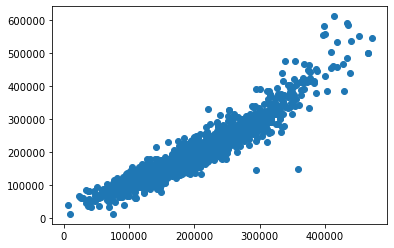

In [41]:
plt.scatter(lasso_best2.predict(Z2),y2);

In [42]:
# Creating the DataFrame for submission
kaggle_sub2 = pd.DataFrame({
    'Id': kaggle['Id'],
    'SalePrice': SalePrice2
})

In [43]:
# Creating the csv file
kaggle_sub2.to_csv('../submissions/Kaggle_sub_final2.csv', index=False)

Kaggle RMSE score for this model was 32546.34 which was not a big improvement considering that more variables were added into the model. 

### Kaggle Submission 3 & 4

Submissions 3 & 4 will be using both Lasso and Ridge regularization of model 5.

In [44]:
# Creating function to change categorical variable to numeric variables
def group_by_price(col_name):
    col_name = kaggle_sub.groupby(col_name)['saleprice'].mean()
    col_name = col_name.to_dict()
    
    for key, value in col_name.items():
        if value == (np.nan) or value == 'nan':
            col_name[key] = 0
        else:
            col_name[key] = round((col_name[key]/100000),2)
            
    return col_name

In [45]:
subclass_dict = group_by_price('ms_subclass')
subclass_dict

{20: 1.89,
 30: 0.95,
 40: 1.19,
 45: 1.16,
 50: 1.37,
 60: 2.39,
 70: 1.53,
 75: 2.05,
 80: 1.7,
 85: 1.54,
 90: 1.39,
 120: 2.12,
 150: 1.48,
 160: 1.38,
 180: 1.1,
 190: 1.24}

In [46]:
kaggle_sub['ms_subclass_value'] =kaggle_sub['ms_subclass'].apply(
    lambda x: subclass_dict[x]
)

In [47]:
zone_dict = group_by_price('ms_zoning')
zone_dict

{'A (agr)': 0.47,
 'C (all)': 0.78,
 'FV': 2.19,
 'I (all)': 0.58,
 'RH': 1.49,
 'RL': 1.91,
 'RM': 1.29}

In [48]:
kaggle_sub['ms_zoning_value'] = kaggle_sub['ms_zoning'].apply(
    lambda x: zone_dict[x]
)

In [49]:
config_dict = group_by_price('lot_config')
config_dict 

{'Corner': 1.81, 'CulDSac': 2.3, 'FR2': 1.75, 'FR3': 1.99, 'Inside': 1.77}

In [50]:
kaggle_sub['lot_config_value'] = kaggle_sub['lot_config'].apply(
    lambda x: config_dict[x]
)

In [51]:
contour_dict = group_by_price('land_contour') 
contour_dict 

{'Bnk': 1.42, 'HLS': 2.62, 'Low': 1.95, 'Lvl': 1.79}

In [52]:
kaggle_sub['land_contour_value'] = kaggle_sub['land_contour'].apply(
    lambda x: contour_dict[x]
)

In [53]:
lot_shape_dict = group_by_price('lot_shape') 
lot_shape_dict 

{'IR1': 2.12, 'IR2': 2.32, 'IR3': 1.97, 'Reg': 1.63}

In [54]:
kaggle_sub['lot_shape_value'] = kaggle_sub['lot_shape'].apply(
    lambda x: lot_shape_dict[x]
)

In [55]:
heating_dict = group_by_price('heating') 
heating_dict 

{'Floor': nan,
 'GasA': 1.82,
 'GasW': 1.51,
 'Grav': 0.65,
 'OthW': 1.26,
 'Wall': 0.77}

In [56]:
ames['Heating'].value_counts()

GasA    2013
GasW      20
Wall       6
Grav       5
OthW       2
Name: Heating, dtype: int64

In [57]:
kaggle_sub['heating_value'] = kaggle_sub['heating'].apply(
    lambda x: heating_dict[x]
)

In [58]:
kaggle_sub['heating_value'].isnull().sum()

1

In [59]:
sale_type_dict = group_by_price('sale_type') 
sale_type_dict 

{'COD': 1.34,
 'CWD': 1.87,
 'Con': 2.42,
 'ConLD': 1.29,
 'ConLI': 2.08,
 'ConLw': 1.25,
 'New': 2.8,
 'Oth': 1.27,
 'VWD': nan,
 'WD ': 1.75}

In [60]:
kaggle_sub['sale_type_value'] = kaggle_sub['sale_type'].apply(
    lambda x: sale_type_dict[x]
)

In [61]:
exterior_1st_dict = group_by_price('exterior_1st') 
exterior_1st_dict 

{'AsbShng': 1.03,
 'AsphShn': 0.82,
 'BrkComm': 1.31,
 'BrkFace': 1.93,
 'CBlock': 0.93,
 'CemntBd': 2.44,
 'HdBoard': 1.6,
 'ImStucc': 2.62,
 'MetalSd': 1.54,
 'Plywood': 1.7,
 'PreCast': nan,
 'Stone': 2.58,
 'Stucco': 1.39,
 'VinylSd': 2.18,
 'Wd Sdng': 1.42,
 'WdShing': 1.56}

In [62]:
kaggle_sub['exterior_1st_value'] = kaggle_sub['exterior_1st'].apply(
    lambda x: exterior_1st_dict[x]
)

In [63]:
exterior_2nd_dict = group_by_price('exterior_2nd') 
exterior_2nd_dict 

{'AsbShng': 1.07,
 'AsphShn': 1.32,
 'Brk Cmn': 1.4,
 'BrkFace': 1.88,
 'CBlock': 0.92,
 'CmentBd': 2.4,
 'HdBoard': 1.6,
 'ImStucc': 2.27,
 'MetalSd': 1.56,
 'Other': nan,
 'Plywood': 1.66,
 'PreCast': nan,
 'Stone': 1.45,
 'Stucco': 1.47,
 'VinylSd': 2.18,
 'Wd Sdng': 1.46,
 'Wd Shng': 1.54}

In [64]:
kaggle_sub['exterior_2nd'] = kaggle_sub['exterior_2nd'].apply(
    lambda x: exterior_2nd_dict[x]
)

In [65]:
functional_dict = group_by_price('functional') 
functional_dict 

{'Maj1': 1.63,
 'Maj2': 0.87,
 'Min1': 1.54,
 'Min2': 1.5,
 'Mod': 1.48,
 'Sal': 0.32,
 'Sev': 0.96,
 'Typ': 1.84}

In [66]:
kaggle_sub['functional_value'] = kaggle_sub['functional'].apply(
    lambda x: functional_dict[x]
)

In [67]:
foundation_dict = group_by_price('foundation') 
foundation_dict 

{'BrkTil': 1.29,
 'CBlock': 1.48,
 'PConc': 2.28,
 'Slab': 1.09,
 'Stone': 1.43,
 'Wood': 1.74}

In [68]:
kaggle_sub['foundation_value'] = kaggle_sub['foundation'].apply(
    lambda x: foundation_dict[x]
)

In [69]:
condition_1_dict = group_by_price('condition_1') 
condition_1_dict 

{'Artery': 1.29,
 'Feedr': 1.43,
 'Norm': 1.85,
 'PosA': 2.55,
 'PosN': 2.55,
 'RRAe': 1.4,
 'RRAn': 1.73,
 'RRNe': 1.3,
 'RRNn': 1.98}

In [70]:
kaggle_sub['condition_1_value'] = kaggle_sub['condition_1'].apply(
    lambda x: condition_1_dict[x]
)

In [71]:
bldg_type_dict = group_by_price('bldg_type') 
bldg_type_dict 

{'1Fam': 1.85, '2fmCon': 1.23, 'Duplex': 1.39, 'Twnhs': 1.33, 'TwnhsE': 1.98}

In [72]:
kaggle_sub['bldg_type_value'] = kaggle_sub['bldg_type'].apply(
    lambda x: bldg_type_dict[x]
)

In [73]:
house_style_dict = group_by_price('house_style') 
house_style_dict 

{'1.5Fin': 1.36,
 '1.5Unf': 1.12,
 '1Story': 1.8,
 '2.5Fin': 2.44,
 '2.5Unf': 1.92,
 '2Story': 2.06,
 'SFoyer': 1.49,
 'SLvl': 1.66}

In [74]:
kaggle_sub['house_style_value'] = kaggle_sub['house_style'].apply(
    lambda x: house_style_dict[x]
)

As there are some new values for some columns, it resulted in null values for their particular category. As represent only 1 of the values each, I have decided to fill them with the mean value of their categories

In [75]:
kaggle_sub['heating_value'] = kaggle_sub['heating_value'].fillna(kaggle_sub['heating_value'].mean())
kaggle_sub['sale_type_value'] = kaggle_sub['sale_type_value'].fillna(kaggle_sub['sale_type_value'].mean())
kaggle_sub['exterior_1st_value'] = kaggle_sub['exterior_1st_value'].fillna(kaggle_sub['exterior_1st_value'].mean())
kaggle_sub['exterior_2nd'] = kaggle_sub['exterior_2nd'].fillna(kaggle_sub['exterior_2nd'].mean())

In [76]:
kaggle_sub_dummies5 = pd.get_dummies(
    data=kaggle_sub,
    drop_first=True,
    columns=[
         'central_air'
])

In [77]:
x_var_model_kaggle_3 = kaggle_sub_dummies5.drop(columns= [
    # features to keep
    #'overall_qual', 'gr_liv_area','garage_area',
    #'age','totrms_abvgrd',
    #'all_baths', 'exter_qual', 'total_bsmt_sf',
    #'bsmt_qual', 'mas_vnr_area', 'heating_qc'
    #'fireplaces', 'exter_cond'
    #'wood_deck_sf', 'open_porch_sf'
    
    
    # unwanted features
    'id', 'pid', 'lot_frontage', 'lot_area', 
    #'street',
    'utilities','land_slope','neighborhood', 'condition_2',
    'overall_cond', 'year_built','year_remod/add','roof_style',
    'roof_matl', 'mas_vnr_type', 'bsmt_cond',
    'bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1', 'bsmtfin_type_2',
    'bsmtfin_sf_2','bsmt_unf_sf', 'electrical', '1st_flr_sf',
    '2nd_flr_sf', 'low_qual_fin_sf', 'bsmt_full_bath', 'bsmt_half_bath',
    'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',
    'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars',
    'garage_qual', 'garage_cond', 'paved_drive', 
    'enclosed_porch', '3ssn_porch', 'screen_porch',
    'pool_area', 'misc_val', 'mo_sold', 'yr_sold',
    'age_since_remodel', 'sale_type', 'exterior_1st', 'exterior_2nd',
    'functional', 'foundation', 'condition_1', 'bldg_type',
    'house_style', 'ms_subclass','ms_zoning', 'lot_config', 
    'land_contour', 'lot_shape','heating', 
    
    # y to be kept
    #'saleprice'
])

In [78]:
# Separating the data sets
x_var_model3 = x_var_model_kaggle_3.dropna()
kaggle_model3 = x_var_model_kaggle_3[x_var_model_kaggle_3['saleprice'].isna()]


In [107]:
len(features_K3)

31

In [106]:
features_K3

['overall_qual',
 'mas_vnr_area',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'total_bsmt_sf',
 'heating_qc',
 'gr_liv_area',
 'kitchen_qual',
 'totrms_abvgrd',
 'fireplaces',
 'garage_area',
 'wood_deck_sf',
 'open_porch_sf',
 'age',
 'neighborhood_value',
 'all_baths',
 'ms_subclass_value',
 'ms_zoning_value',
 'lot_config_value',
 'land_contour_value',
 'lot_shape_value',
 'heating_value',
 'sale_type_value',
 'exterior_1st_value',
 'functional_value',
 'foundation_value',
 'condition_1_value',
 'bldg_type_value',
 'house_style_value',
 'central_air_Y']

In [79]:
# Creating a list of the columns excluding saleprice
features_K3 = [col for col in kaggle_model3._get_numeric_data().columns if col != 'saleprice']

# Assembling X variable for the test dataset
KX3 = kaggle_model3[features_K3]

# Assembling X and y variables.
X3 = x_var_model3[features_K3]
y3 = x_var_model3['saleprice']

# Scale the data set
ss = StandardScaler()
ss.fit(X3)
Z3 = ss.transform(X3)
KZ3 = ss.transform(KX3)

# Instantiate, fit and calculate the alpha
lasso3 = LassoCV(n_alphas=200)
lasso3.fit(Z3, y3)
lasso3.alpha_

387.2305957446834

In [80]:
# Instantiate, fit and calculate the sale price
lasso_best3 = Lasso(alpha=387.2305957446834)

lasso_best3.fit(Z3, y3)

SalePrice3 = lasso_best3.predict(KZ3)

In [81]:
SalePrice3

array([136847.24089073, 190090.32215487, 212394.90857924, 116138.817568  ,
       188343.1941695 ,  88668.64707237,  96170.03640213, 167141.02079516,
       206007.46878289, 174897.468031  , 173542.41525472, 116777.48163259,
       156536.92205689, 272907.69031583, 140989.6060019 ,  92228.60270276,
       171716.4513477 , 115520.33937714, 203611.99162259, 190142.64939403,
       151087.06617875, 116590.79066096, 217340.8227501 , 173125.10422344,
       188236.42401991, 111177.16395606, 143274.86777254, 139074.44361123,
       145685.78204958,  37161.34284004, 103206.85340411, 104693.88684149,
       251582.95407491, 168952.41264743, 224603.493368  , 183484.29010924,
       124158.96288987,  57470.48753606, 107095.95249795, 204553.08696398,
       195554.30238951, 212805.58779095, 151285.80854384, 158480.65682907,
       254783.38517435,  91409.70569641, 225602.81148873, 126809.50678058,
       109224.66569081, 111576.458193  , 110164.29280498, 204923.52434395,
       251452.16065759, 1

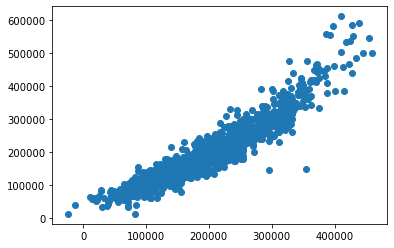

In [82]:
plt.scatter(lasso_best3.predict(Z3),y3);

In [83]:
# Creating a DataFrame for submission
kaggle_sub3 = pd.DataFrame({
    'Id': kaggle['Id'],
    'SalePrice': SalePrice3
})
    

In [84]:
# Creating a csv file
kaggle_sub3.to_csv('../submissions/Kaggle_sub_final3.csv', index=False)

Kaggle RMSE score for this model was 32687.03522. Changing the categorical variables to numeric variables did not help to improve the model. 

#### Performing Ridge regularization on  Model 3

In [85]:
# Instantiate, fit and calculate the alpha
ridge3 = RidgeCV(alphas=np.logspace(0, 10, 200))
ridge3.fit(Z3, y3)
ridge3.alpha_


32.17641750250737

In [86]:
# Instantiate, fit and calculate the saleprice
ridge_best3 = Ridge(alpha=32.17641750250737)

ridge_best3.fit(Z3, y3)

SalePrice4 = ridge_best3.predict(KZ3)

In [87]:
SalePrice4

array([137670.12094754, 186029.03592468, 213787.34705378, 115180.3672922 ,
       190279.71682974,  87623.95342973,  93478.68885425, 166502.01488403,
       204538.83087883, 175877.31102652, 170810.93585712, 118441.2176436 ,
       155605.40573745, 272869.94804443, 139255.00663944,  89718.75547875,
       171784.75378588, 114919.70476175, 204942.02038864, 192265.51459718,
       153625.15639263, 119065.9179801 , 215968.4568645 , 176978.53666694,
       187068.61407593, 109806.29615897, 146980.80467608, 139749.87980134,
       144763.06183849,  40219.05986233, 101970.2105019 , 104363.936764  ,
       254187.40835847, 169433.87546366, 223494.93357622, 181939.20993975,
       124064.13743742,  60039.61311519, 107447.48412766, 205293.86852402,
       196337.92381104, 210473.3031686 , 150712.88708331, 159111.82115538,
       259372.18825379,  88827.89533376, 226218.68776291, 129137.24045651,
       110300.30930995, 110544.36755687, 109630.64699359, 209031.93070784,
       250569.87884899, 1

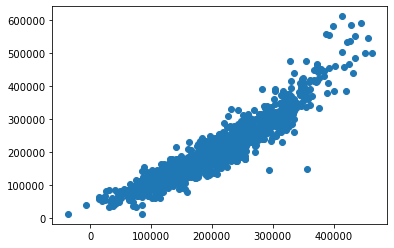

In [88]:
plt.scatter(ridge_best3.predict(Z3),y3);

In [89]:
# Creating DataFrame for submission
kaggle_sub4 = pd.DataFrame({
    'Id': kaggle['Id'],
    'SalePrice': SalePrice4
})
    

In [90]:
# Creating csv file
kaggle_sub4.to_csv('../submissions/Kaggle_sub_final4.csv', index=False)

Kaggle RMSE score for this model was 32808.96174. This is similar to the 4th submission using lasso regularization.

### Kaggle Submissions 5 & 6

The last 2 submission is using model 6 which include polynomial transformation of model 5.

In [91]:
# Instantiate polynomial features
poly = PolynomialFeatures(include_bias=False, degree=2)

In [92]:
# Transforming the data
X_poly = poly.fit_transform(X3)
KX_poly = poly.fit_transform(KX3)

In [93]:
# Scaling the data to the train data set
ss = StandardScaler()
ss.fit(X_poly)

Z_poly = ss.transform(X_poly)
KZ_poly = ss.transform(KX_poly)

In [94]:
# Instantiate, fit and calculate the alpha
lasso4 = LassoCV(n_alphas=200)
lasso4.fit(Z_poly, y3)
lasso4.alpha_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1054054873.2426758, tolerance: 1041025138.1661294
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144256687186.66272, tolerance: 1284644078.472668
  model = cd_fast.enet_coordinate_descent(


71.62390874077583

In [95]:
# Instantiate, fit and calculate the saleprice
lasso_best4 = Lasso(alpha=71.62390874077583)

lasso_best4.fit(Z_poly, y3)

SalePrice5 = lasso_best4.predict(KZ_poly)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144256687186.66272, tolerance: 1284644078.472668
  model = cd_fast.enet_coordinate_descent(


In [96]:
SalePrice5

array([117254.92713263, 171423.33090994, 190493.90832531, 101849.16364321,
       191875.16429232,  99127.9415404 , 106195.34972589, 162324.04132169,
       184612.48787259, 161014.99571471, 162933.69592319, 111999.85281803,
       159685.54553021, 271874.38731452, 141392.69135712, 113349.87156899,
       158064.500683  , 125681.06116864, 184914.11035554, 183950.56399244,
       148725.95850043, 134937.5561425 , 218572.88863797, 175567.30998054,
       175489.26712759, 115637.27607524, 148924.03524469, 126788.85535586,
       141019.7431765 ,  78334.22566654, 112900.84703806, 103829.33376381,
       222884.10495449, 163522.74348933, 218139.98649089, 162358.47926447,
       107301.55457323,  91466.65171823, 114756.84417252, 189224.31095385,
       155530.37338077, 206330.11905813, 147088.23751442, 133987.5161997 ,
       243898.35343732, 100292.42504321, 226105.58998885, 128124.73054553,
       124754.18382493, 121979.83583348, 111781.75546302, 196166.12919438,
       249136.06086439, 1

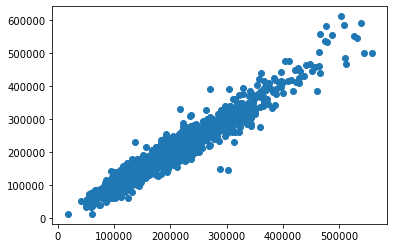

In [97]:
plt.scatter(lasso_best4.predict(Z_poly),y3);

In [98]:
# Creating the DataFrame for submission
kaggle_sub5 = pd.DataFrame({
    'Id': kaggle['Id'],
    'SalePrice': SalePrice5
})
    

In [99]:
# Creating the csv file
kaggle_sub5.to_csv('../submissions/Kaggle_sub_final5.csv', index=False)

Kaggle RMSE score for this model was 23593.98203. This is the best RMSE score so far. It can be seen by the curve which closely mimics a linear regression line.

#### Performing Ridge regularization on this model instead

In [100]:
# Instantiate, fit and calculate the best alpha
ridge4 = RidgeCV(alphas=np.logspace(0, 10, 200))
ridge4.fit(Z_poly, y3)
ridge4.alpha_


72.32633896483537

In [101]:
# Instantiate, fit and calculate the Saleprice
ridge_best4 = Ridge(alpha=72.32633896483537)

ridge_best4.fit(Z_poly, y3)

SalePrice6 = ridge_best4.predict(KZ_poly)

In [102]:
SalePrice6

array([116940.05456206, 173404.25791213, 196590.51886403,  99826.27202829,
       190788.29300375,  99056.96407154, 104639.85078837, 163186.73351264,
       191796.09788102, 166635.81221983, 161313.759456  , 111561.44065627,
       159358.17813223, 279568.78727771, 142046.7954526 , 110186.84762581,
       165339.73576234, 125399.47799401, 183108.50146808, 182037.30387199,
       154286.87638056, 127482.40239999, 217569.14237996, 175568.31390929,
       174777.34991295, 115796.82850577, 147053.47732264, 123877.96735619,
       142701.0695155 ,  75708.44979777, 112803.53380674, 103199.99930037,
       219279.50789328, 166232.71332745, 216363.27097041, 165866.86807729,
       113133.7183931 ,  89311.14408109, 114720.60839739, 195510.00989846,
       159960.61218093, 206847.98338412, 146034.87988606, 136322.17034319,
       244581.29911228,  99996.73011379, 225149.65493975, 126218.93825942,
       124968.22497382, 120859.96964461, 113078.18772014, 199363.67061472,
       248250.25691606, 1

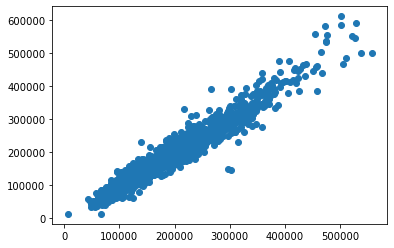

In [103]:
plt.scatter(ridge_best4.predict(Z_poly),y3);

In [104]:
# Create DataFrame for submission
kaggle_sub6 = pd.DataFrame({
    'Id': kaggle['Id'],
    'SalePrice': SalePrice6
})
    

In [105]:
# Creating csv file
kaggle_sub6.to_csv('../submissions/Kaggle_sub_final6.csv', index=False)

Kaggle RMSE score for this model was 24070.73086. This is very close to the lasso regulation of the same model.